### Logistics First partial case study

+ Valentin Martinez  A01024435
+ Mariela Romano A01024382
+ Eduardo Garza  A01024129
+ Jorge Serrano A01024490
+ Manek Roffiel A01024194


# Logistics Case Study 1 - Transshipment problem

For this first partial case study we must optimze the transhipment of of goods within a supply network conformed by 1 orgin node, 1 destination node and 3 inter nodes also called echelon node. 

We must cover the demand at the end node _Retail stores_, this while **minimizing** the transportation and handling costs across the chain need to get the products from the origin node _Raw material suppliers_ to the end node.

The supply chain nodes and order are presented in the following picture.

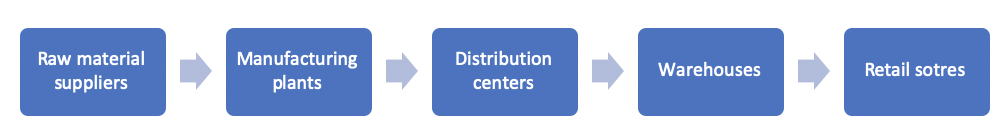



As previously stated the objective is:

>  "to design the flow of the products within the supply network from raw material suppliers to retail stores, e.g. solve the transportation problem at a minimum cost (facility operation costs + transportation costs) while meeting all demand requirements at retail stores.""

Considering the following constraints:

>+ Any facility can be closed or remain open  
>+ Manufacturing plants, distribution centers, and warehouses (transshipment nodes) have unlimited capacity
>+ Raw material suppliers must all operate at a maximum of 90% of their capacity
>+ Demand at the retail stores be met at 100%
>+ Distribution centers cannot receive products from two or more different plant. That is, there are single source constraints for distribution centers. All other stages of the supply chain (plants, warehouses, and retail stores) do not have this constraint.

>Notes: Consider the fixed cost of Retail Stores to be $9,500

### Using Julia JuMP to build the model

The previously stated objective and constraints are the base for building an optimization mathematical model. Fot this case study we will try to define a linear model using linear programing. The model will be construted on top of **Julia JuMP**

**Julia** Julia is a high-level, high-performance, dynamic programming language. While it is a general purpose language and can be used to write any application, many of its features are well-suited for numerical analysis and computational science. **JuMP** is a domain-specific modeling language for mathematical optimization embedded in Julia. This interactive report and the embedded code needed to showcase the work are built on top of **Jupyter Notebook**.
***
<br>

## The Model in Julia

First we will decalre the libraries used by our Julia program. JuMP for building our model. The Cbc solver for linear optimization. CSV to work with csv files and Pretty Tables to better output our data.

In [1]:
using JuMP, Cbc, CSV, DataFrames, PrettyTables
ENV["COLUMNS"] = 100
ENV["LINES"] = 40

40

### Importing relevant Data

We can visualize the problem's data in an imported Julia Dataframe

In [2]:
caseData = CSV.read("case-study.csv", header = false)
caseData = coalesce.(caseData, "-")

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String,String,String,String,String,String,String
1,-,Costs ($ per 5 units),-,-,-,-,-
2,-,Manufacturing Plants,-,-,-,-,-
3,Raw material supplier,Atlanta,Boston,Chicago,Denver,Capacity,Fixed cost $/1000
4,Baltimore,$500,$410,$230,$300,"1,850",$33.60
5,Cheyenne,$260,$300,$480,$500,"1,590",$47.25
6,Santa Fe,$400,$260,$370,$340,"1,810",$40.95
7,Salt Lake,$340,$380,$250,$370,"1,950",$47.25
8,-,-,-,-,-,"7,200",-
9,-,Costs ($ per 10 units),-,-,-,-,-


-


To be able to better handle the problems data we divided each nodes information into a separate table. The Costs were simplified to a per unit cost and the Fixed Cost are now showed in dollars.

In [3]:
Raw_Plants_Data = CSV.read("Raw-Plants.csv", header=true)
Plants_DC_Data = CSV.read("Plants-DC.csv", header=true)
DC_Wares_Data = CSV.read("DC-Wares.csv", header=true)
Wares_Stores_Data = CSV.read("Wares-Stores.csv", header=true)

,Wares\Stores,LA,San Antonio,NY,Oklahoma City,Annual Fixed cost Thousand$
,String,Float64,Float64,Float64,Float64,Int64?
1,Kentucky,12.5,16.25,18.75,23.75,19950
2,Amarillo,15.0,25.0,20.0,22.5,31500
3,Nebraska,12.5,13.75,12.5,20.0,18900
4,Arizona,17.5,23.75,21.25,16.25,18900
5,Total demand,1100.0,1750.0,1575.0,1500.0,missing
6,Fixed Cost,9500.0,9500.0,9500.0,9500.0,missing


Next, the individidual cost and fixed matrices were extracted from this tables

In [4]:
Raw_Plants_Costs = Matrix{Float64}(Raw_Plants_Data[1:4,2:5])
Plants_DC_Costs = Matrix{Float64}(Plants_DC_Data[1:4,2:5])
DC_Wares_Costs = Matrix{Float64}(DC_Wares_Data[1:4,2:5])
Wares_Stores_Costs = Matrix{Float64}(Wares_Stores_Data[1:4,2:5])

Raw_Fixed = Array{Float64}(Raw_Plants_Data[1:4,6])
Plants_Fixed = Array{Float64}(Plants_DC_Data[1:4,6])
DC_Fixed = Array{Float64}(DC_Wares_Data[1:4,6])
Wares_Fixed = Array{Float64}(Wares_Stores_Data[1:4,6])
Stores_Fixed = 9500

Raw_Supply = Array{Float64}(Raw_Plants_Data[1:4,7])
Store_Demand = transpose(Array{Float64}(Wares_Stores_Data[5,2:5]))

1×4 LinearAlgebra.Transpose{Float64,Array{Float64,1}}:
 1100.0  1750.0  1575.0  1500.0

It is important to note here that all echelon nodes along with the raw materials origin and the retail stores end have 4 facilities each. And so to iterate over the facilities of any nodes one will need to iterate over this 4 facilities. To simplify such operations further down the code a constant _numF_, short for number of facilities was created to make further code more readable.

In [ ]:
numF = 4

<br>


### Building the Model

In [6]:
caseModel = Model(Cbc.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: COIN Branch-and-Cut (Cbc)

#### Variables
First we declare all relevant variables for the model.

Starting with a Matrix that describes the amount of units from one facility in a node to facility in the one:

In [7]:
@variables(caseModel, begin
    RawToPlants[1:numF,1:numF] >= 0, Int
    PlantsToDC[1:numF,1:numF] >= 0, Int
    DCToWares[1:numF,1:numF] >= 0, Int
    WaresToStores[1:numF,1:numF] >= 0, Int
end)

Next a group of Vectors that describes which facilities in a node are open which will be usefull for determining the fixed costs in each node:


In [8]:
@variables(caseModel, begin
    RawOpen[1:numF], Bin
    PlantsOpen[1:numF], Bin
    DCOpen[1:numF], Bin
    WaresOpen[1:numF], Bin
    StoresOpen[1:numF], Bin
end)

#### Objective

Now we must establish the objective for our model, in this case minimizing both the variable and fixed costs.

In [9]:
fixedCosts = @expression(caseModel, 
      sum(RawOpen.*Raw_Fixed) 
    + sum(PlantsOpen.*Plants_Fixed) 
    + sum(DCOpen.*DC_Fixed) 
    + sum(WaresOpen.*Wares_Fixed) 
    + sum(StoresOpen.*Stores_Fixed)
)

variableCosts = @expression(caseModel, 
      sum(RawToPlants.*Raw_Plants_Costs) 
    + sum(PlantsToDC.*Plants_DC_Costs) 
    + sum(DCToWares.*DC_Wares_Costs) 
    + sum(WaresToStores.*Wares_Stores_Costs))

@objective(caseModel, Min, fixedCosts + variableCosts);


#### Constraints

Now we must add the appropiate constraints to the Model. 

First we will add the special constraints as specified in the case study description.
>+ Raw material suppliers must all operate at a maximum of 90% of their capacity
>+ Demand at the retail stores be met at 100%
>+ Distribution centers cannot receive products from two or more different plant. That is, there are single source constraints for distribution centers.

In [10]:
for n = 1:numF
    @constraints(caseModel, begin
        sum(RawToPlants[n,1:numF]) <= Raw_Supply[n]*.9*RawOpen[n]
        sum(WaresToStores[1:numF,n]) >= Store_Demand[n]
        PlantsToDC[:,n] in SOS1()
    end)
end

Next we must add the constraints needed to impose a logical flow of products across the echeleon nodes. This is achivied by stating that the number of units entering a facility within a node should equal the aumount of units leaving that same facility towards the next node.

In [11]:
for n = 1:numF  
    @constraints(caseModel, begin
        sum(RawToPlants[:,n]) == sum(PlantsToDC[n,:])
        sum(PlantsToDC[:,n]) == sum(DCToWares[n,:])
        sum(DCToWares[:,n]) == sum(WaresToStores[n,:])
    end)
end

Finally we must add the last constraints that force the model to recognize which facilities are open by relating the capacity of the facilities in the echelon nodes to the binary variables that establish if those facilities are opened. In this case if a binary variable doe not set "open" a facility its capacity will be reduced to 0. Otherwise it will have unlimited capacity.

In [12]:
for n = 1:numF  
    @constraints(caseModel, begin
        sum(RawToPlants[:,n]) <= PlantsOpen[n]*typemax(Int)
        sum(PlantsToDC[:,n]) <= DCOpen[n]*typemax(Int)
        sum(DCToWares[:,n]) <= WaresOpen[n]*typemax(Int)
        sum(WaresToStores[:,n]) <= StoresOpen[n]*typemax(Int)
    end)
end

### Running the model

Now that we have built the model it is time to run it and analyze the results

In [13]:
JuMP.optimize!(caseModel)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 733097 - 0.03 seconds
Cgl0003I 4 fixed, 48 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 32 rows, 80 columns (80 integer (16 of which binary)) and 192 elements
Cbc0031I 12 added rows had average density of 14.333333
Cbc0013I At root node, 12 cuts changed objective from 800011.24 to 889976.75 in 8 passes
Cbc0014I Cut generator 0 (Probing) - 24 row cuts average 2.0 elements, 1 column cuts (1 active)  in 0.000 seconds - new frequency is 1
Cbc0014I Cut generator 1 (Gomory) - 39 row cuts average 47.3 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.002 seconds - new frequency is -100
Cbc0014I Cut generator 3 (Clique) - 0 row cuts average 0.0 elements, 0 column c

The previous output shows some relevant information on how to Solver found the optimal solution for the model.

The most important value in here is the value obtained for the objective function which corresponded to the total costs of transshipment which we wanted to minimize.

> Subject ot the stated restrictions the minimum cost possible is:
```$926,554.25```

And the final results on the amount of units that must be sent from a facility in a node to a facility in the next node is presented in the following table:

In [15]:
resultsData = CSV.read("case-results.csv", header = false)
resultsData = coalesce.(resultsData, "-")

resultsData[4:7,2:5] = string.(round.(JuMP.value.(RawToPlants)))
resultsData[12:15,2:5] = string.(round.(JuMP.value.(PlantsToDC)))
resultsData[20:23,2:5] = string.(round.(JuMP.value.(DCToWares)))
resultsData[28:31,2:5] = string.(round.(JuMP.value.(WaresToStores)))

resultsData[4:7,7] = string.(round.(JuMP.value.(RawOpen).*Raw_Fixed))
resultsData[12:15,7] = string.(round.(JuMP.value.(PlantsOpen).*Plants_Fixed))
resultsData[20:23,7] = string.(round.(JuMP.value.(DCOpen).*DC_Fixed))
resultsData[28:31,7] = string.(round.(JuMP.value.(WaresOpen).*Wares_Fixed)) 
resultsData[33,2:5] = string.(round.(JuMP.value.(StoresOpen).*Stores_Fixed))
CSV.write("saved-results.csv", resultsData, header=false)

resultsData

,Column1,Column2,Column3,Column4,Column5,Column6,Column7
,String,String,String,String,String,String,String
1,Raw To Plants,-,-,-,-,-,-
2,-,Manufacturing Plants,-,-,-,-,-
3,Raw material supplier,Atlanta,Boston,Chicago,Denver,Capacity,Fix Costs
4,Baltimore,0.0,0.0,1665.0,0.0,"1,850",33600.0
5,Cheyenne,0.0,876.0,0.0,0.0,"1,590",47250.0
6,Santa Fe,0.0,1629.0,0.0,0.0,"1,810",40950.0
7,Salt Lake,0.0,0.0,1755.0,0.0,"1,950",47250.0
8,-,-,-,-,-,"7,200",-
9,Plants to DC,-,-,-,-,-,-


---
That is all for this first case. Thank you for your time in reviewing this information
